In [ ]:
# Reinforcement Learning Lab 2, Problem 2, produce ALL the plots
# Oscar Eriksson, 0011301991, oscer@kth.se
# Philip Ahrendt, 960605R119, pcah@kth.se

In [4]:
# Load packages
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange
from torch import nn
from DDPG_agent import RandomAgent
from DDPG import Actor, Critic
from DDPG_soft_updates import soft_updates

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

Episode:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_169751/3031554204.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((batch_size, -1)), zip(*sample_experience_replay_buffer(batch_size)))
Episode 299 - Reward/Steps: -259.6/168 - Avg. Reward/Steps: -255.6/222: 100%|██████████| 300/300 [15:13<00:00,  3.04s/it] 


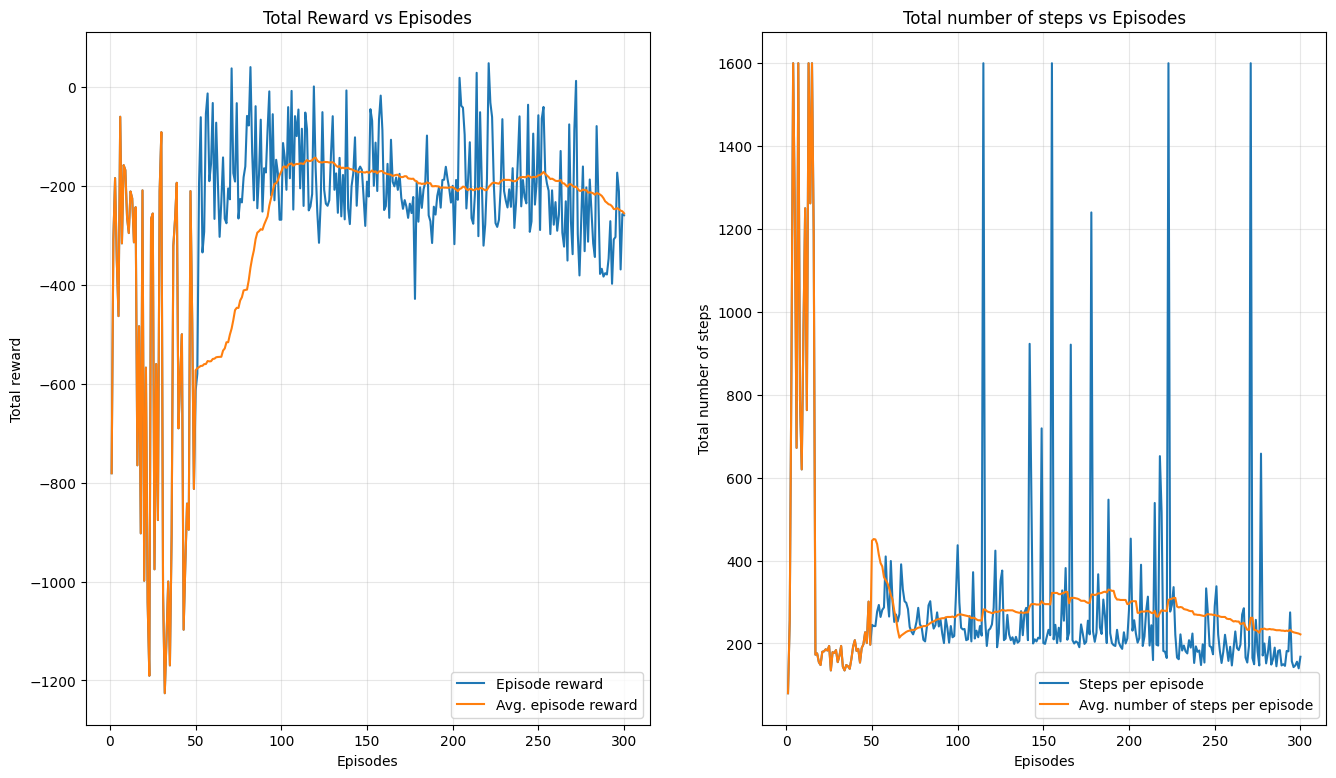

Episode 299 - Reward/Steps: 262.6/179 - Avg. Reward/Steps: 191.9/445: 100%|██████████| 300/300 [53:00<00:00, 10.60s/it]    


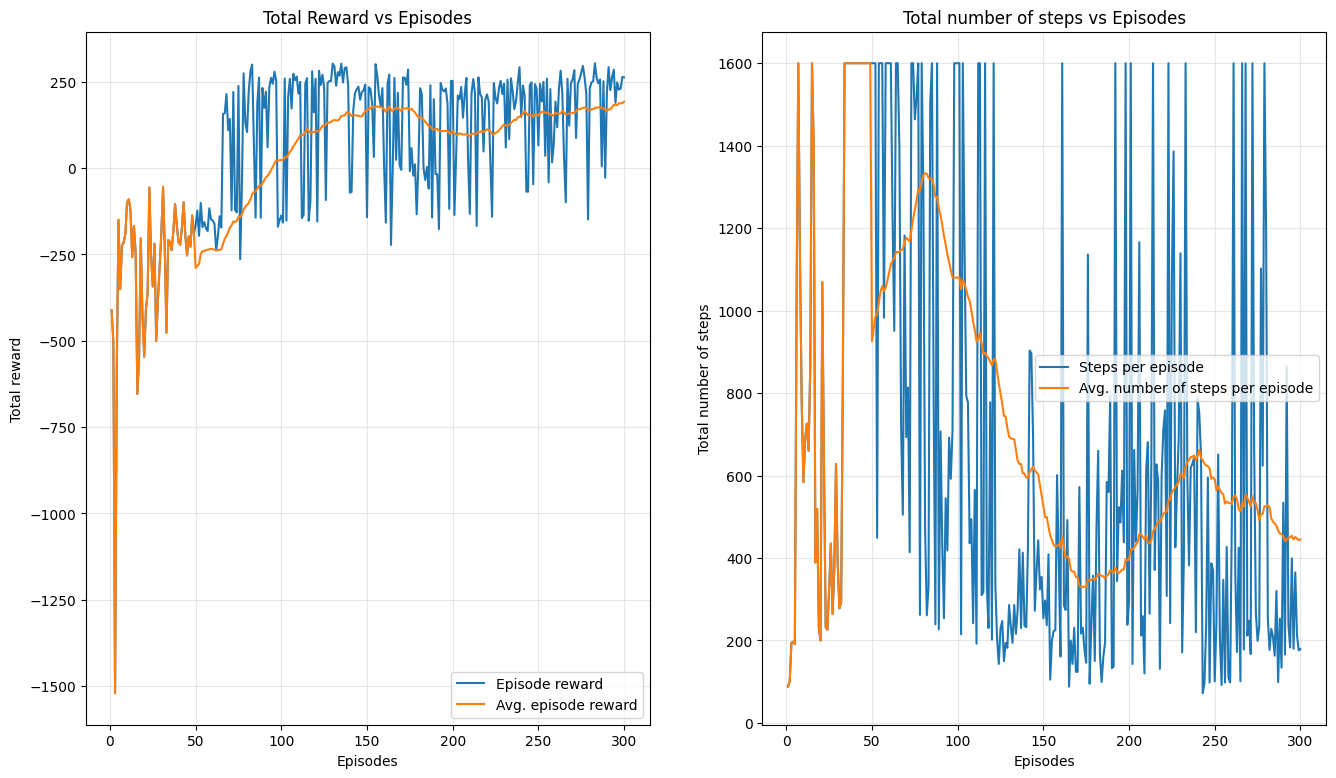

Episode 299 - Reward/Steps: 276.6/218 - Avg. Reward/Steps: 210.8/319: 100%|██████████| 300/300 [38:44<00:00,  7.75s/it]    


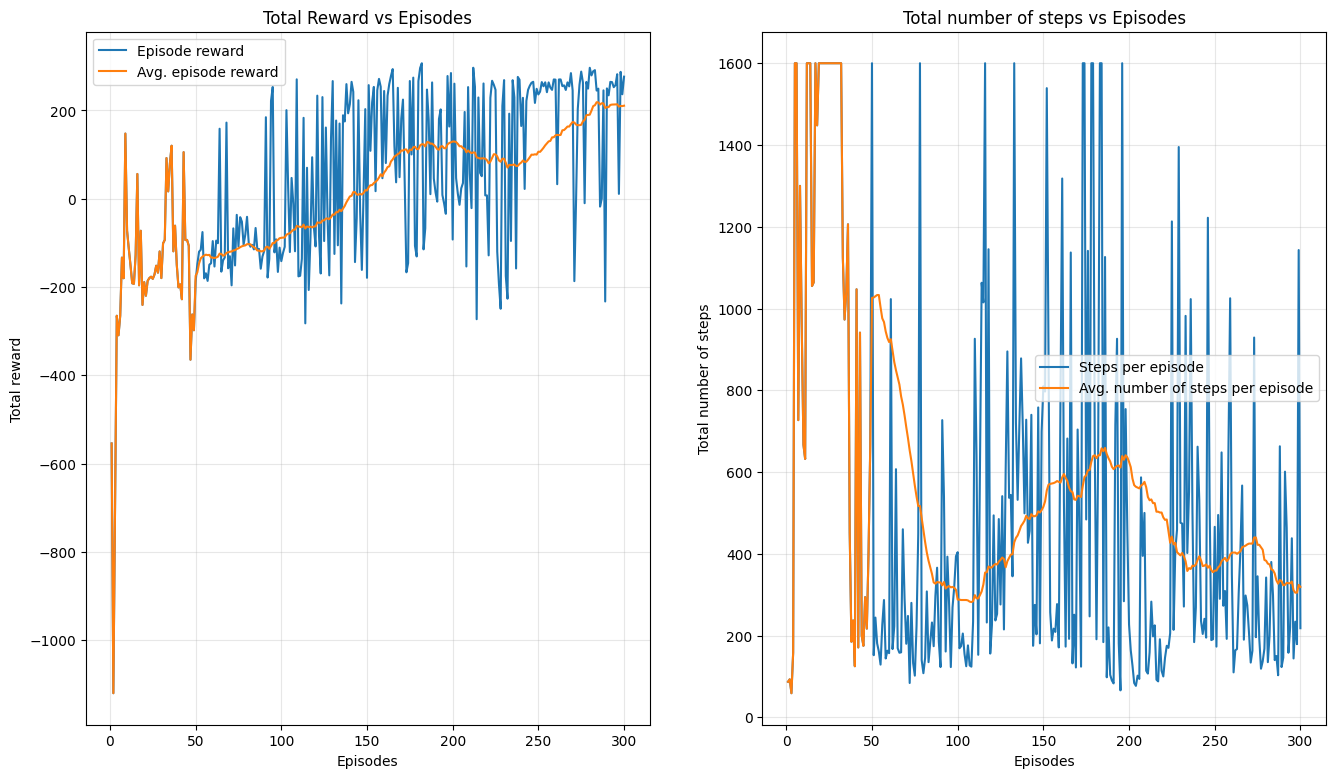

In [2]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

# Hyperparameters
ERB_size = 30000
epsilon0 = 0.99
batch_size = 64
N_episodes = 300
discount_factor = 0.99
learning_rate = 0.0005
tau = 0.001
d = 2
mu = 0.15
sigma = 0.2
hidden_layer_size = 64

for discount_factor in [ 0.2, 0.99, 1 ]:
    episode_reward_list = [] 
    episode_number_of_steps = [] 
    # Experience replay buffer
    experience_replay_buffer = deque(maxlen=ERB_size)
    def sample_experience_replay_buffer(batch_size):
        indices = np.random.choice(len(experience_replay_buffer), batch_size, replace=False)
        return [ experience_replay_buffer[index] for index in indices ]
    
    # Initialize networks, optimizer and loss function
    
    target_actor = Actor(S, A)
    target_critic = Critic(S, A)
    network_actor = Actor(S, A)
    network_critic = Critic(S, A)
    
    optimizer_critic = torch.optim.Adam(network_critic.parameters(), lr=learning_rate)
    optimizer_actor = torch.optim.Adam(network_actor.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    # Functions used to update the networks
    def train_target(network_actor: Actor, network_critic: Critic, target_actor: Actor, target_critic: Critic):
        soft_updates(network_actor, target_actor, tau)
        soft_updates(network_critic, target_critic, tau)
    
    def train_network_critic(network_actor: Actor, network_critic: Critic, target_actor: Actor, target_critic: Critic):
        # create torch tensors from experience replay buffer
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((batch_size, -1)), zip(*sample_experience_replay_buffer(batch_size)))
    
        # compute loss
        y = rewards + discount_factor * target_critic(next_states, target_actor(states)) * (1 - dones)
        q = network_critic(states, actions)
        loss = loss_fn(y, q)
    
        # train
        optimizer_critic.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(network_critic.parameters(), max_norm=1)
        optimizer_critic.step()
    
    def train_network_actor(network_actor: Actor, network_critic: Critic):
        # create torch tensors from experience replay buffer
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float(), zip(*sample_experience_replay_buffer(batch_size)))
    
        # compute loss
        loss = -torch.mean(network_critic(states, network_actor(states)))
    
        # train
        optimizer_actor.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(network_actor.parameters(), max_norm=1)
        optimizer_actor.step()
    
    while True:
        done = False
        state, _ = env.reset()
        for _ in range(1600):
            if done: break
            action = RandomAgent(m).forward(state)
            next_state, reward, done, _, _ = env.step(action)
            
            experience_replay_buffer.append((state, action, reward, next_state, done))
            
            state = next_state
    
        if len(experience_replay_buffer) == ERB_size:
            break
        
    noise = np.zeros((1, 2,))
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
    for i in EPISODES:
        done = False
        state, _ = env.reset()
        total_episode_reward = 0.
        epsilon = epsilon0 * np.exp(- 3 * i / N_episodes)
        t = 0
        #while not done:
            # act
        for _ in range(1600):
            if done: break
            action = network_actor.act(state, noise).ravel()
            next_state, reward, done, _, _ = env.step(action)
            total_episode_reward += reward
    
            # train
            train_network_critic(network_actor, network_critic, target_actor, target_critic)
            if t % d == 0:
                train_network_actor(network_actor, network_critic)
                train_target(network_actor, network_critic, target_actor, target_critic)
            
            # update
            experience_replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            t += 1
            noise = -mu * noise + sigma * np.random.randn(1, 2)
    
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)
    
        env.close()
    
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
        #if running_average(episode_reward_list, n_ep_running_average)[-1] > 200:
        #    break
    
    while len(episode_reward_list) < N_episodes:
        episode_reward_list.append(episode_reward_list[-1])
        episode_number_of_steps.append(episode_number_of_steps[-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
    ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_reward_list, n_ep_running_average), label='Avg. episode reward')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Total reward')
    ax[0].set_title('Total Reward vs Episodes')
    ax[0].legend()
    ax[0].grid(alpha=0.3)
    
    ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
    ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Total number of steps')
    ax[1].set_title('Total number of steps vs Episodes')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.show()

Episode 299 - Reward/Steps: 239.9/216 - Avg. Reward/Steps: 219.1/334: 100%|██████████| 300/300 [41:26<00:00,  8.29s/it]    


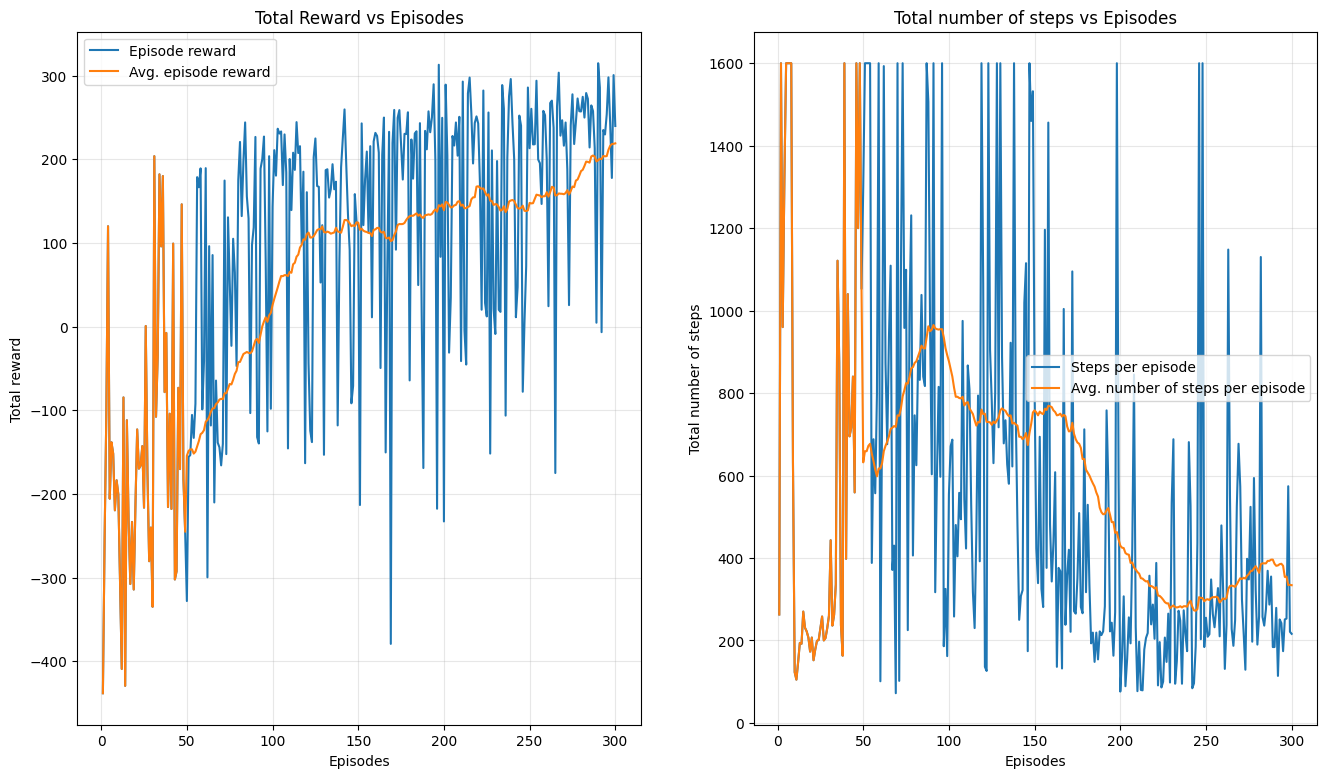

Episode 299 - Reward/Steps: 7.6/118 - Avg. Reward/Steps: 177.5/513: 100%|██████████| 300/300 [9:34:51<00:00, 114.97s/it]      


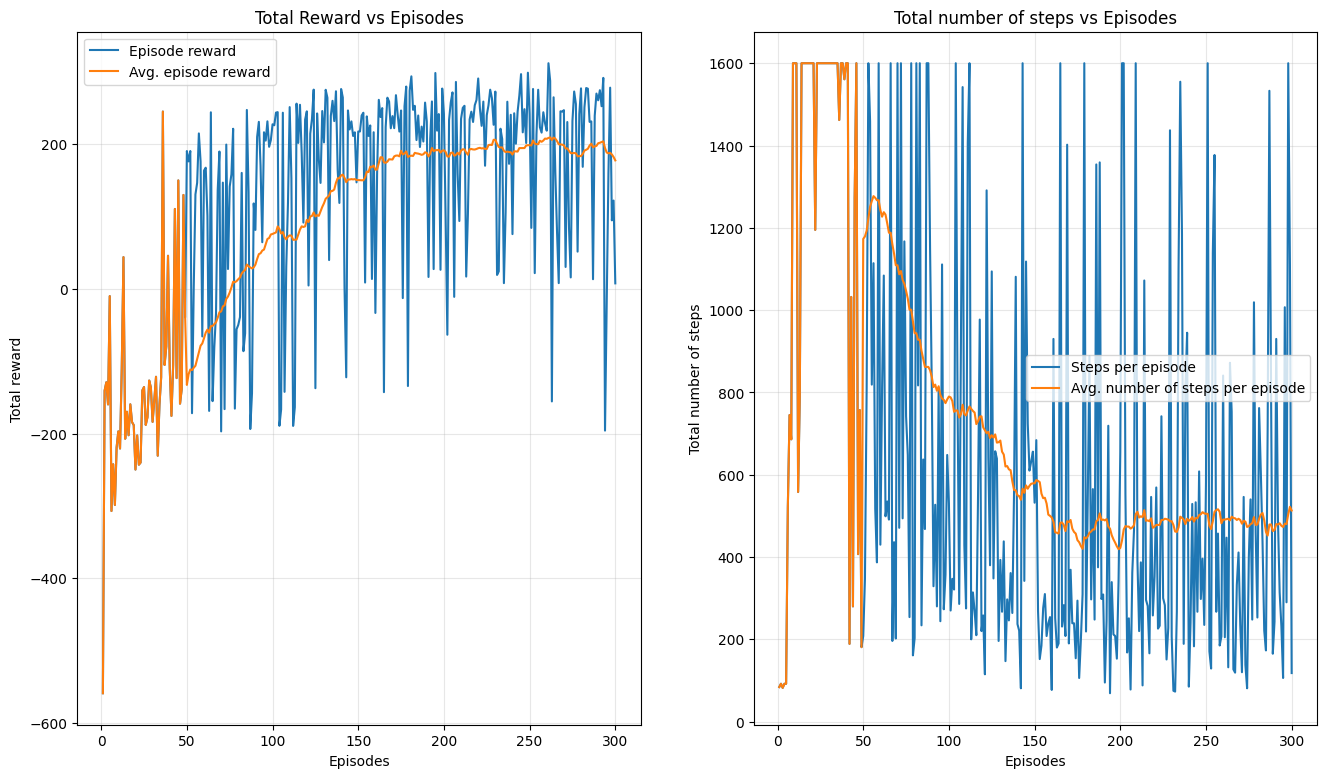

Episode 299 - Reward/Steps: 275.6/240 - Avg. Reward/Steps: 250.6/404: 100%|██████████| 300/300 [5:54:16<00:00, 70.85s/it]      


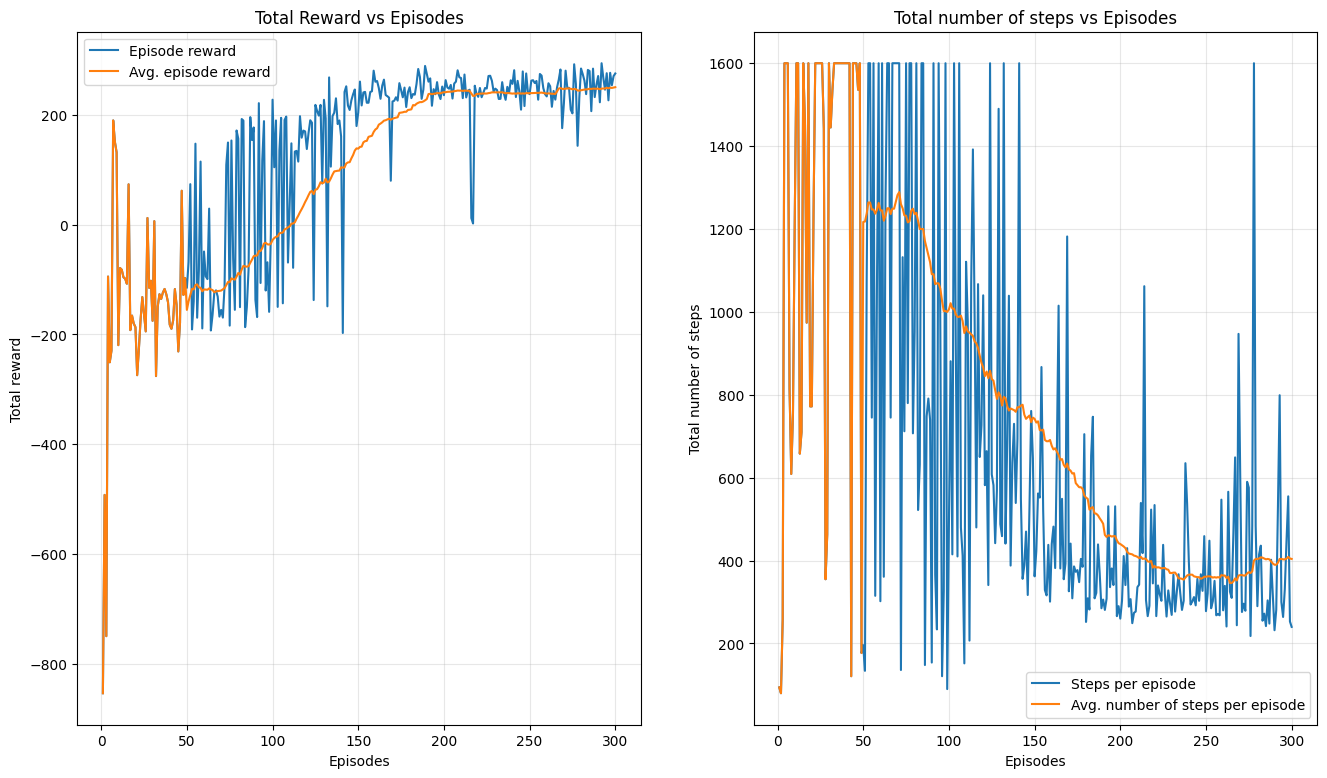

In [3]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

# Hyperparameters
ERB_size = 30000
epsilon0 = 0.99
batch_size = 64
N_episodes = 300
discount_factor = 0.99
learning_rate = 0.0005
tau = 0.001
d = 2
mu = 0.15
sigma = 0.2
hidden_layer_size = 64

for ERB_size in [ 10000, 30000, 50000 ]:
    episode_reward_list = [] 
    episode_number_of_steps = [] 
    # Experience replay buffer
    experience_replay_buffer = deque(maxlen=ERB_size)
    def sample_experience_replay_buffer(batch_size):
        indices = np.random.choice(len(experience_replay_buffer), batch_size, replace=False)
        return [ experience_replay_buffer[index] for index in indices ]
    
    # Initialize networks, optimizer and loss function
    
    target_actor = Actor(S, A)
    target_critic = Critic(S, A)
    network_actor = Actor(S, A)
    network_critic = Critic(S, A)
    
    optimizer_critic = torch.optim.Adam(network_critic.parameters(), lr=learning_rate)
    optimizer_actor = torch.optim.Adam(network_actor.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    
    # Functions used to update the networks
    def train_target(network_actor: Actor, network_critic: Critic, target_actor: Actor, target_critic: Critic):
        soft_updates(network_actor, target_actor, tau)
        soft_updates(network_critic, target_critic, tau)
    
    def train_network_critic(network_actor: Actor, network_critic: Critic, target_actor: Actor, target_critic: Critic):
        # create torch tensors from experience replay buffer
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((batch_size, -1)), zip(*sample_experience_replay_buffer(batch_size)))
    
        # compute loss
        y = rewards + discount_factor * target_critic(next_states, target_actor(states)) * (1 - dones)
        q = network_critic(states, actions)
        loss = loss_fn(y, q)
    
        # train
        optimizer_critic.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(network_critic.parameters(), max_norm=1)
        optimizer_critic.step()
    
    def train_network_actor(network_actor: Actor, network_critic: Critic):
        # create torch tensors from experience replay buffer
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float(), zip(*sample_experience_replay_buffer(batch_size)))
    
        # compute loss
        loss = -torch.mean(network_critic(states, network_actor(states)))
    
        # train
        optimizer_actor.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(network_actor.parameters(), max_norm=1)
        optimizer_actor.step()
    
    while True:
        done = False
        state, _ = env.reset()
        for _ in range(1600):
            if done: break
            action = RandomAgent(m).forward(state)
            next_state, reward, done, _, _ = env.step(action)
            
            experience_replay_buffer.append((state, action, reward, next_state, done))
            
            state = next_state
    
        if len(experience_replay_buffer) == ERB_size:
            break
        
    noise = np.zeros((1, 2,))
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
    for i in EPISODES:
        done = False
        state, _ = env.reset()
        total_episode_reward = 0.
        epsilon = epsilon0 * np.exp(- 3 * i / N_episodes)
        t = 0
        #while not done:
            # act
        for _ in range(1600):
            if done: break
            action = network_actor.act(state, noise).ravel()
            next_state, reward, done, _, _ = env.step(action)
            total_episode_reward += reward
    
            # train
            train_network_critic(network_actor, network_critic, target_actor, target_critic)
            if t % d == 0:
                train_network_actor(network_actor, network_critic)
                train_target(network_actor, network_critic, target_actor, target_critic)
            
            # update
            experience_replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            t += 1
            noise = -mu * noise + sigma * np.random.randn(1, 2)
    
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)
    
        env.close()
    
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
        #if running_average(episode_reward_list, n_ep_running_average)[-1] > 200:
        #    break
    
    while len(episode_reward_list) < N_episodes:
        episode_reward_list.append(episode_reward_list[-1])
        episode_number_of_steps.append(episode_number_of_steps[-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
    ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_reward_list, n_ep_running_average), label='Avg. episode reward')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Total reward')
    ax[0].set_title('Total Reward vs Episodes')
    ax[0].legend()
    ax[0].grid(alpha=0.3)
    
    ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
    ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Total number of steps')
    ax[1].set_title('Total number of steps vs Episodes')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.show()

Episode 4 - Reward/Steps: 280.3/168 - Avg. Reward/Steps: 0.0/0:   8%|▊         | 4/50 [00:00<00:04, 10.87it/s]

Episode 49 - Reward/Steps: 261.9/181 - Avg. Reward/Steps: 236.3/276: 100%|██████████| 50/50 [00:16<00:00,  3.11it/s]


[]

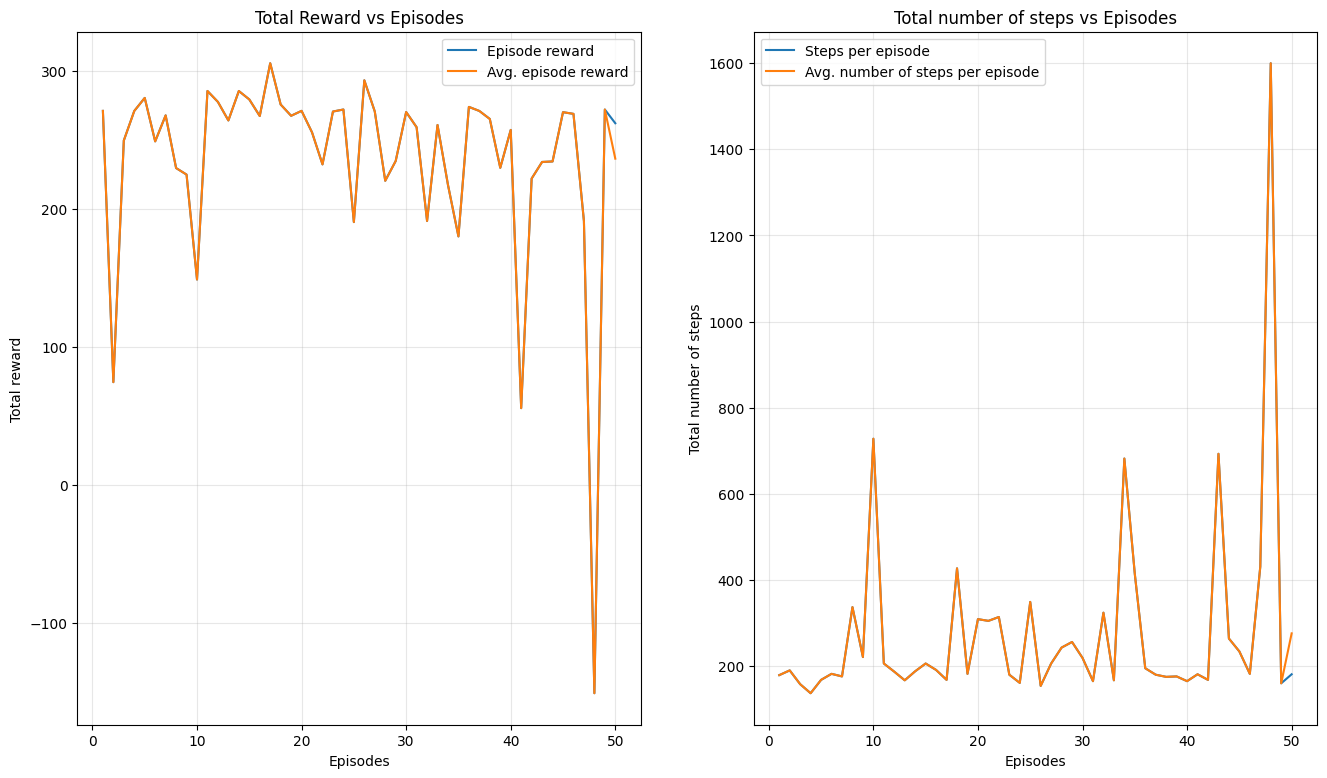

In [6]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

N_episodes = 50
episode_reward_list = [] 
episode_number_of_steps = [] 

# Initialize networks, optimizer and loss function
model = torch.load('neural-network-2-actor.pth')

EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    t = 0
    for _ in range(1600):
        if done: break
        action = model.act(state, 0).ravel()
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        state = next_state
        t += 1

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.plot()

Episode 49 - Reward/Steps: -35.6/212 - Avg. Reward/Steps: -181.3/141: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


[]

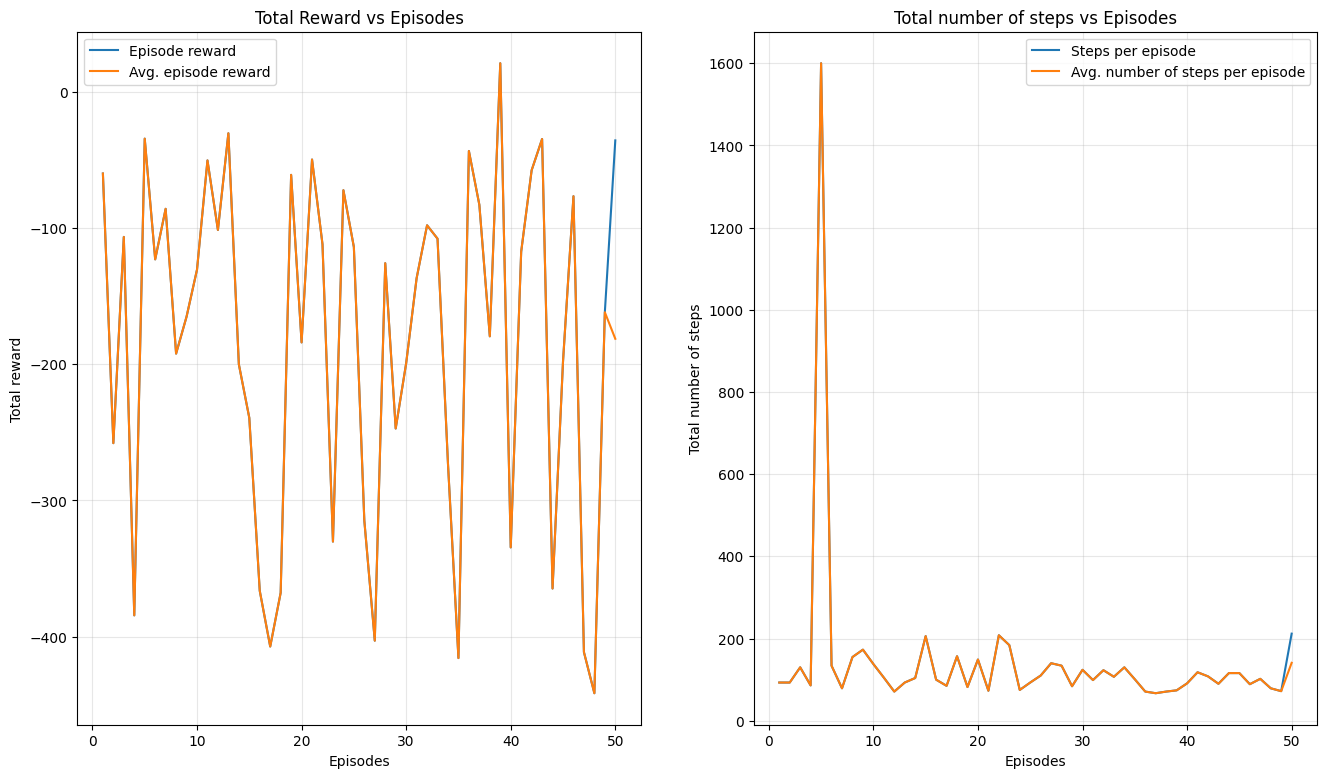

In [7]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

N_episodes = 50
episode_reward_list = [] 
episode_number_of_steps = [] 

# Initialize networks, optimizer and loss function
model = RandomAgent(m)

EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    t = 0
    for _ in range(1600):
        if done: break
        action = model.forward(state).ravel()
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        state = next_state
        t += 1

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.plot()

/tmp/ipykernel_202675/4078124391.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


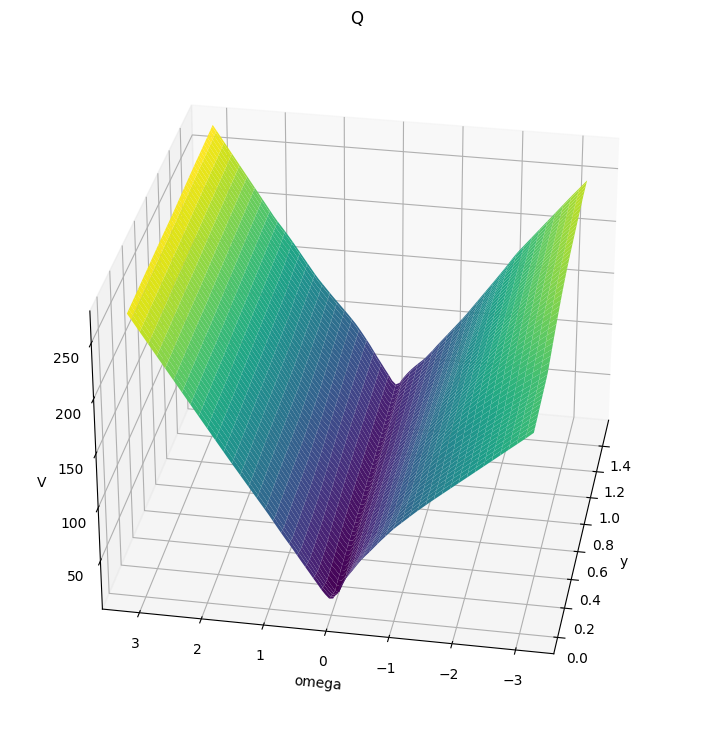

/tmp/ipykernel_202675/4078124391.py:26: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


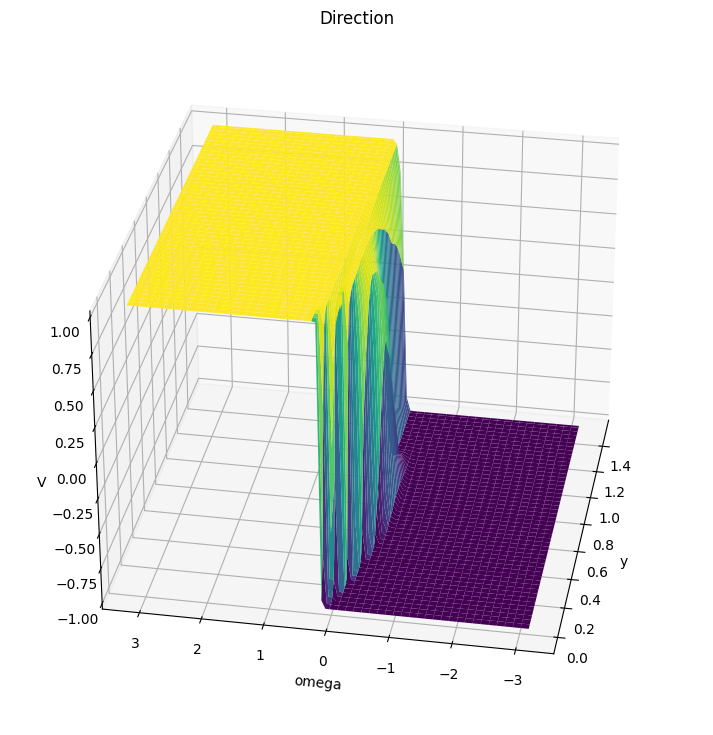

In [2]:
actor = torch.load('neural-network-2-actor.pth')
critic = torch.load('neural-network-2-critic.pth')
v_N = 100
v_y = np.linspace(0, 1.5, v_N)
v_o = np.linspace(-np.pi, np.pi, v_N)

# 3d plot
V_y, V_o = np.meshgrid(v_y, v_o)
V_s = np.zeros((v_N**2, 8))
V_s[:, 1] = V_y.ravel()
V_s[:, 4] = V_o.ravel()
t_s = torch.tensor(V_s).float()
Z = critic(t_s, actor(t_s)).detach().numpy().reshape((v_N, v_N))
U = actor(t_s)[:,1].detach().numpy().reshape((v_N, v_N))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(V_y, V_o, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('omega')
ax.set_zlabel('V')
ax.set_title('Q')
ax.view_init(30, 190)
plt.show()
fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(V_y, V_o, U, cmap='viridis', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('omega')
ax.set_zlabel('V')
ax.set_title('Direction')
ax.view_init(30, 190)
plt.show()